In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

#import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tqdm import tqdm

In [2]:
healthy = sc.read_h5ad("GSE174188/GSE174188_Healthy.h5ad")
healthy

AnnData object with n_obs × n_vars = 486418 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'cg_cov_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [3]:
cell_type = list(set(healthy.obs.cg_cov))
cell_type

['cM', 'cDC', 'Prolif', 'NK', 'B', 'T4', 'PB', 'ncM', 'Progen', 'T8', 'pDC']

In [4]:
sample = list(set(healthy.obs.ind_cov))

personal = {}
for i in sample:
    if i not in personal:
        personal[i] = healthy[healthy.obs.ind_cov == i, :]        
# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))


# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

# Proportion

## total(人)/total(all)

Text(0.5, 1.0, 'Cells proportion in each person')

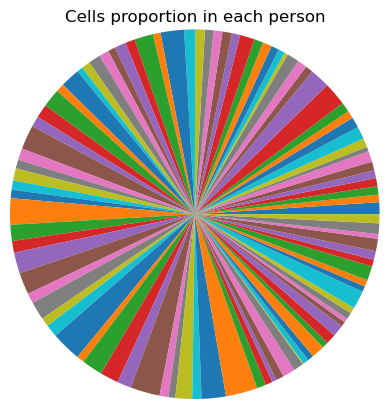

In [5]:
total_cell = 0
person_proportion = []
ID = []
total_cell = healthy.n_obs

for i in sorted_personal:
    total_person_cell = sorted_personal[i].n_obs / total_cell
    ID.append(i)
    person_proportion.append(round(total_person_cell*100,2))
    #print(f"Total(人):{sorted_personal[i].n_obs}\t person Proportion:{round(total_person_cell*100,2)}%")
    
plt.pie(person_proportion, radius = 1.25)
# displaying the title
plt.title("Cells proportion in each person")


## cell type(人)/total(人)

個人所有的細胞 分之 各種cell type

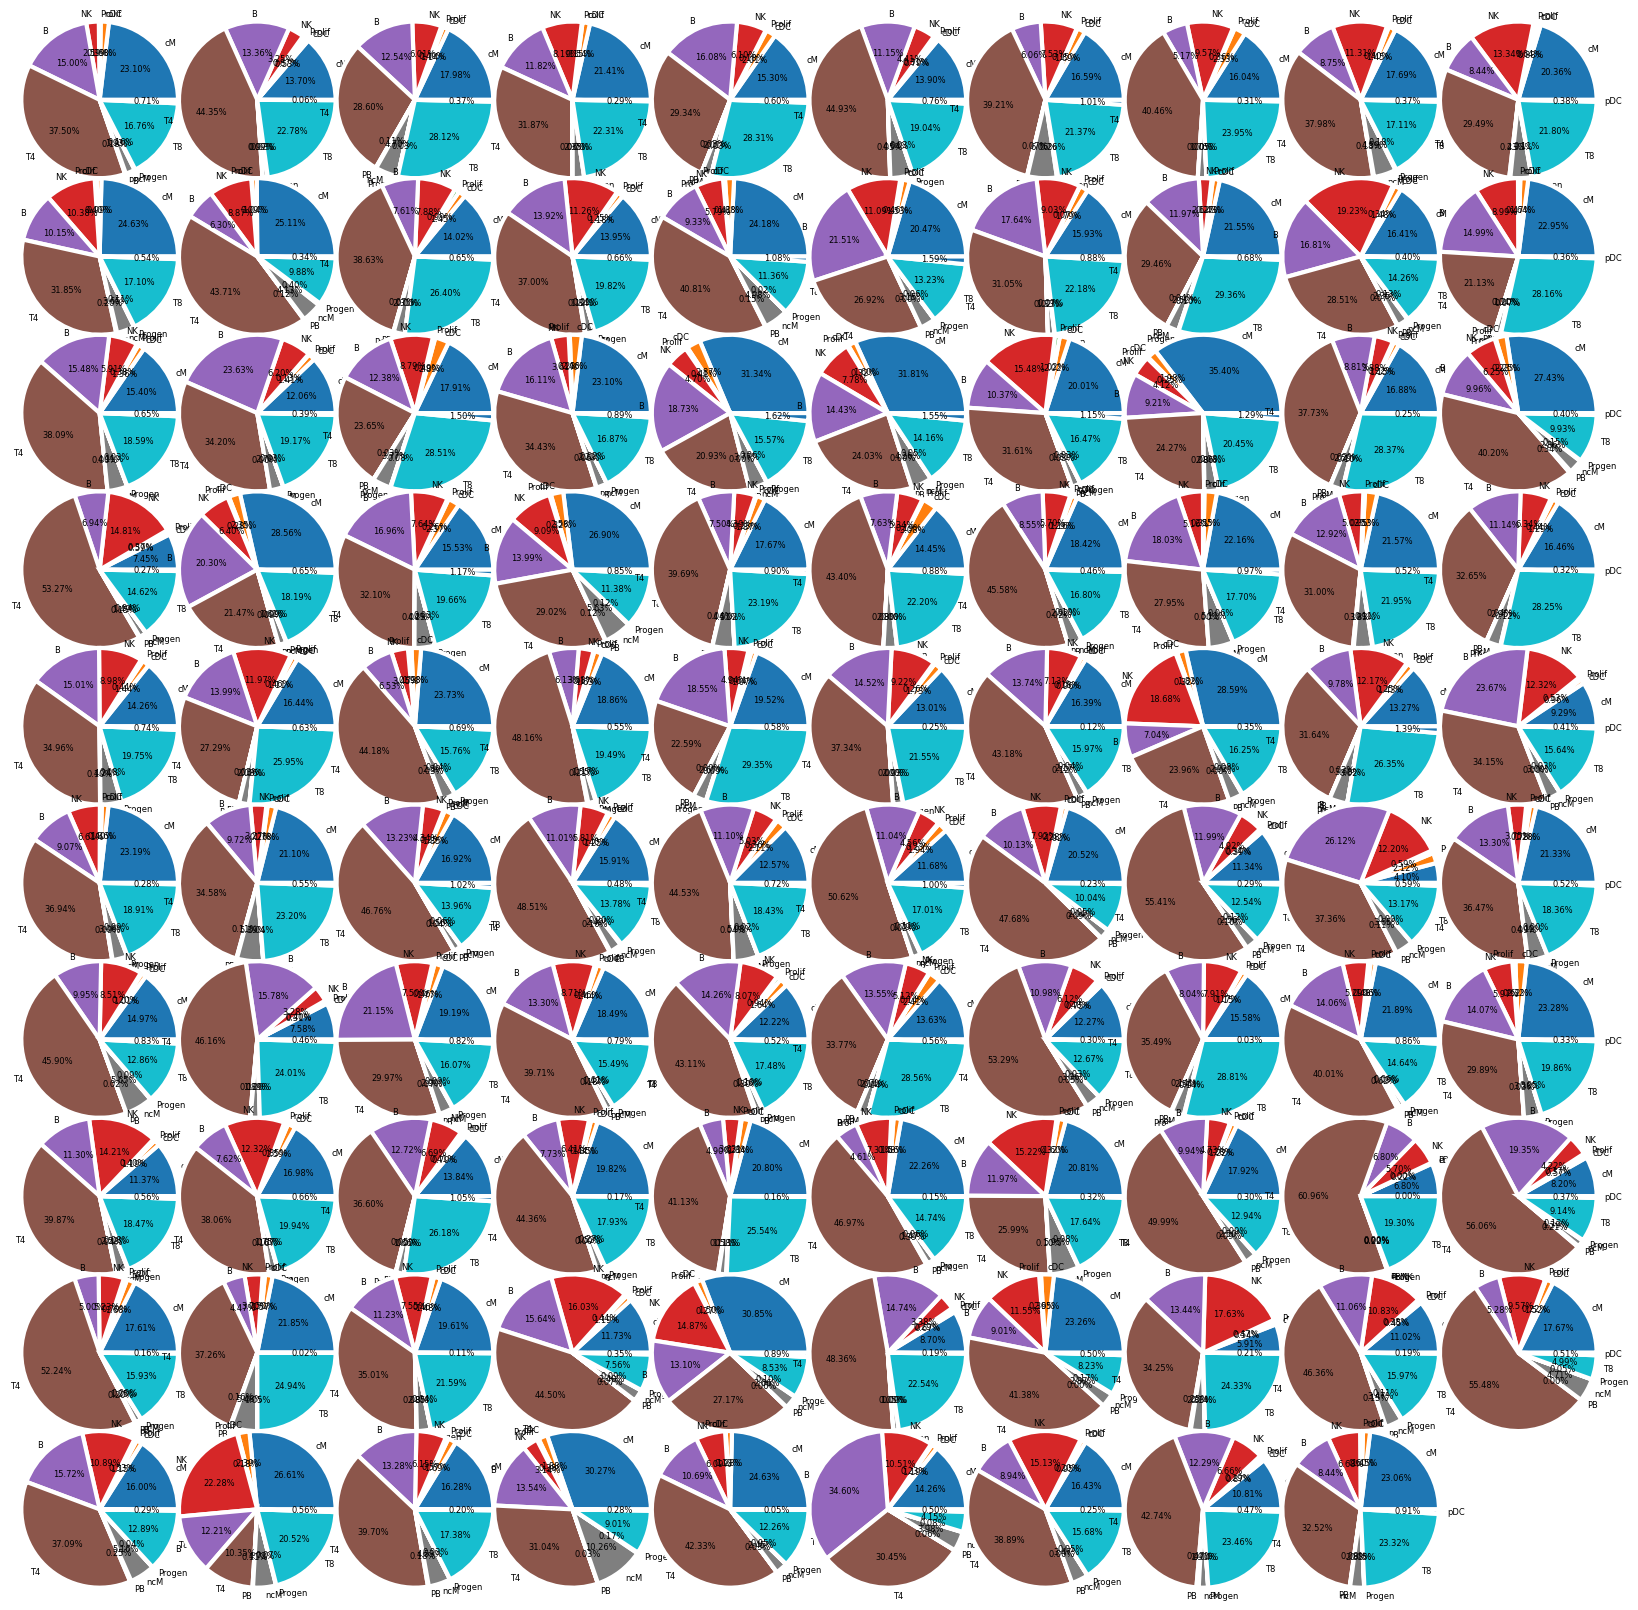

In [6]:
# 創建一個10x10的子圖陣列
fig, axs = plt.subplots(10, 10, figsize=(20,20))

total_personal = []
for i in sorted_personal: # 99人
    person = []
    for j in cell_type: # 11種
        a = sorted_personal[i][sorted_personal[i].obs.cg_cov == j,:].n_obs / sorted_personal[i].n_obs
        person.append(round(a*100, 2))
        #print(f"{i}的{j}佔個人cell type : {round(a*100,2)}%")
    total_personal.append(person)

#畫圖
for i in range(len(total_personal)):
    ax = axs[i//10, i%10]  # 選擇子圖
    ax.pie(total_personal[i], radius = 1.5, labels = cell_type, autopct='%.2f%%', textprops={'size':6}, wedgeprops={'linewidth':3,'edgecolor':'w'})
    
# 刪除最後一格空的位置
plt.delaxes(axs[9, 9])
plt.show()

## cell type(人)/cell type(total)

In [7]:
pie_celltype = {}
for i in cell_type:
    # cell type total
    a = healthy[healthy.obs.cg_cov == i, :]
    pie_celltype[i] = []
    # cell type 
    for j in sorted_personal:
        # cell type by personal
        b = sorted_personal[j][sorted_personal[j].obs.cg_cov == i, :]
        # calculate proportion 
        c = b.n_obs / a.n_obs        
        # 放入這個cell type不同人的比例
        pie_celltype[i].append(round(c*100, 2))        
        #print(f"{j} 的 {i} 佔所有 {i} : {round(c*100, 2)}%")

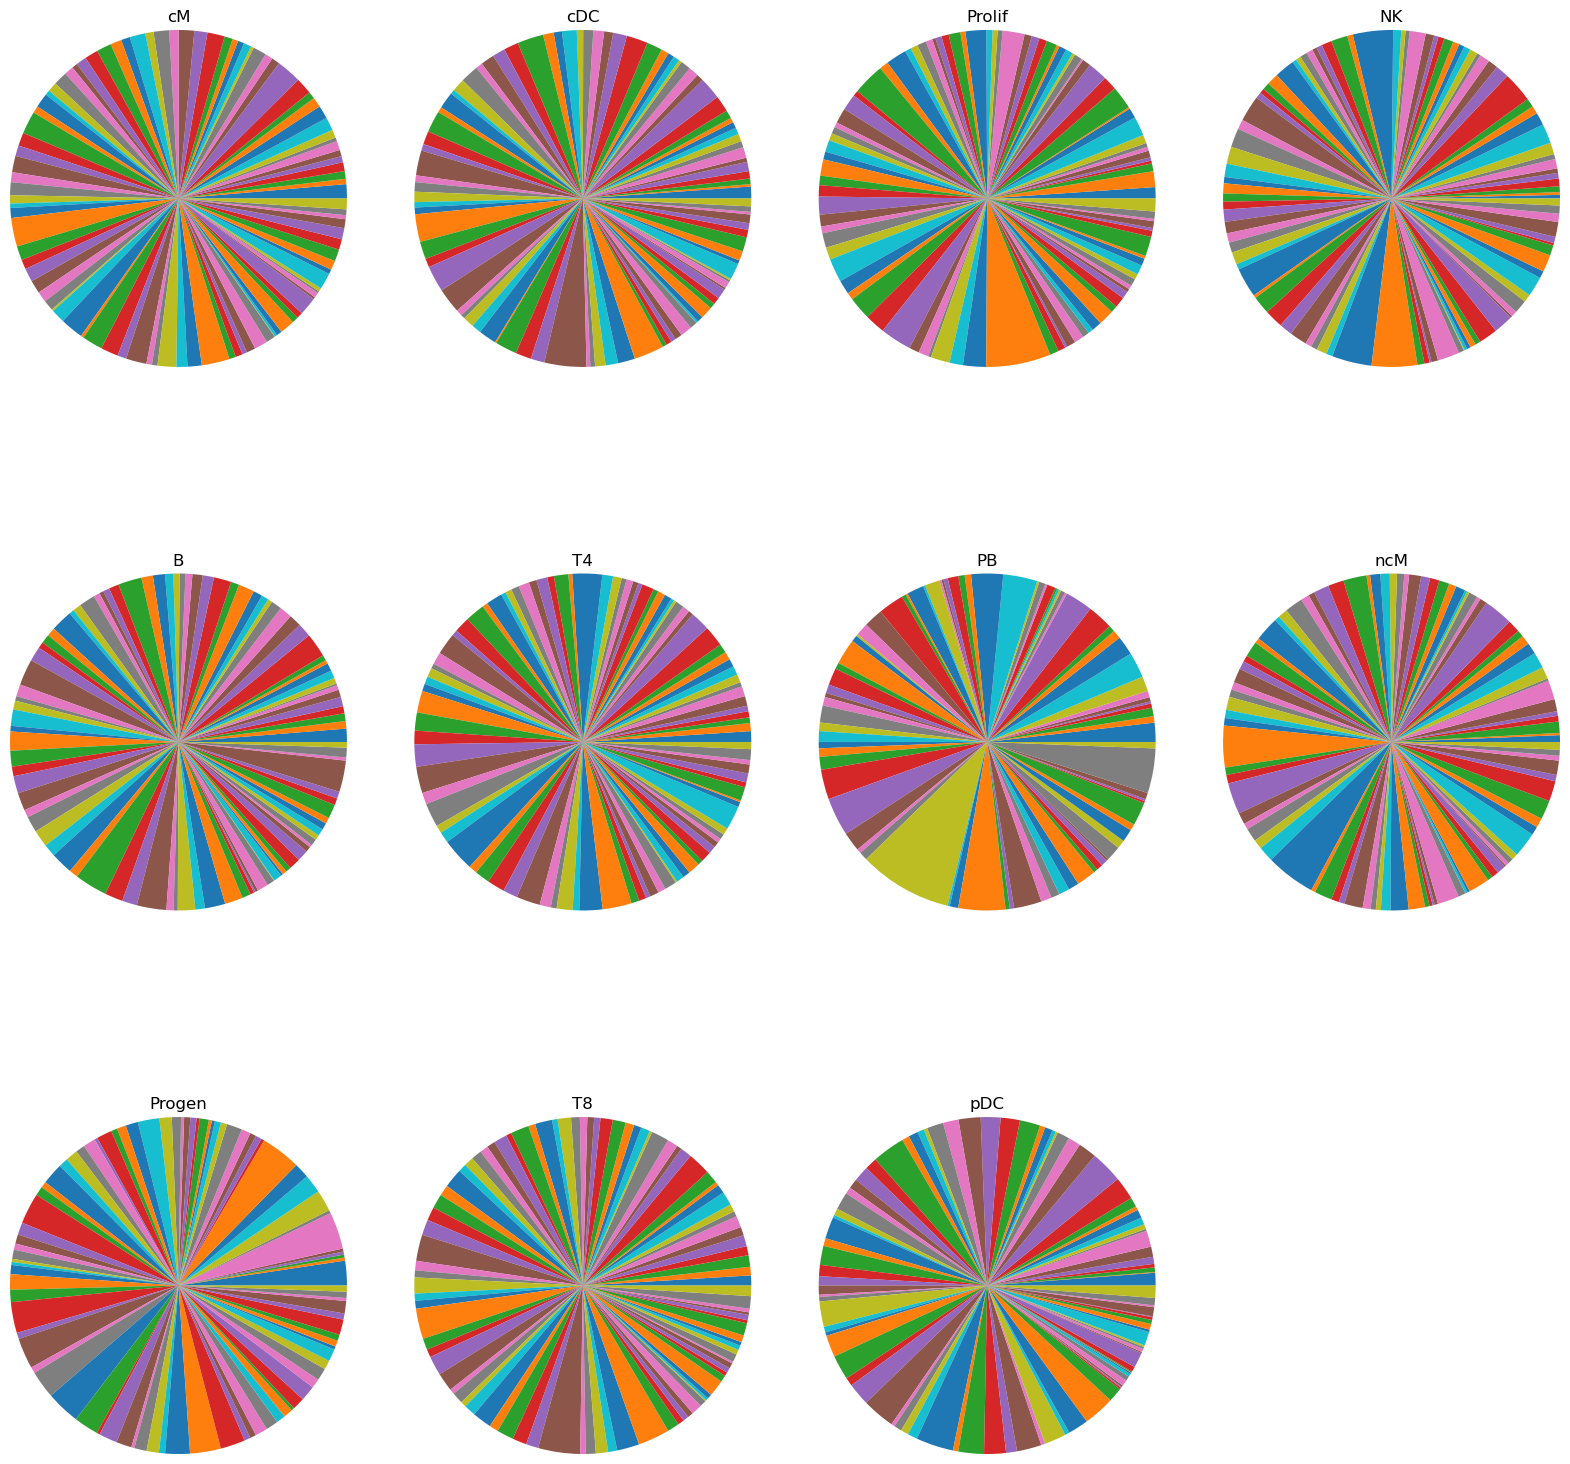

In [8]:
# 創建一個10x10的子圖陣列
fig, axs = plt.subplots(3, 4, figsize=(20,20))
#畫圖
count = 0
for i in pie_celltype:
    ax = axs[count//4, count%4]  # 選擇子圖
    ax.pie(pie_celltype[i], radius = 1.25) # autopct='%.2f%%', textprops={'size':6}
    ax.set_title(i)  # 添加標題
    
    count += 1
    
# 刪除最後一格空的位置
plt.delaxes(axs[2, 3])
plt.show()

# Spearman Correlation

In [9]:
from scipy.stats import spearmanr

def spearman_correlation(adata, cell):
    corr = []
    pvalue = []
    # extract cell type
    cell_type = adata[adata.obs.cg_cov == cell,:]
    # get age and turn into float
    age_float = [float(i) for i in cell_type.obs.Age]
    for gene in cell_type.X.T: # cell_type.X.T才會是基因
        spearman_corr, p_value = spearmanr(age_float, gene)
        corr.append(spearman_corr)
        pvalue.append(p_value)
    
    return corr, pvalue

In [10]:
# ['NK', 'Prolif', 'cDC', 'T8', 'ncM', 'T4', 'cM', 'B', 'PB', 'pDC', 'Progen']
spearman = {}
for i in cell_type:
    corr, pvalue = spearman_correlation(healthy, i)
    spearman[i] = {"corr" : corr, "pvalue" : pvalue}# Pearson Correlation

In [11]:
spearman

{'cM': {'corr': [0.19183800830122513,
   0.12612430162383068,
   0.11194162175006483,
   -0.10896603306589764,
   0.20491359611278293,
   0.1711075751240802,
   0.25750663421229003,
   -0.1710998250607681,
   0.12371283926004503,
   0.11808436561568332,
   0.3041118050342565,
   0.1329256834254782,
   0.09980589206102664,
   0.09858422563336042,
   0.26756827604274286,
   0.19820004445633524,
   0.21700106686964285,
   0.05618051531643302,
   -0.32042062999130605,
   0.28206703233835806,
   0.10932922492168037,
   0.27356644631875615,
   -0.015447858196963335,
   0.26455225720614745,
   0.236079751279834,
   0.22554957050457342,
   0.27823232522284735,
   0.17290098294889444,
   -0.3126054233595046,
   0.040443969765358995,
   0.27632671669563075,
   0.2860610205643861,
   0.21439215565023098,
   0.24012984277859872,
   -0.006011040360283042,
   0.27743362897344626,
   0.16193347517707632,
   0.05644932930949169,
   0.14252419299634594,
   0.23327235030233845,
   0.18802075383610264,
 

# Pearson Correlation

In [12]:
from scipy.stats import pearsonr

def pearson_correlation(adata, cell):
    corr = []
    pvalue = []
    # extract cell type
    cell_type = adata[adata.obs.cg_cov == cell,:]
    # get age and turn into float
    age_float = [float(i) for i in cell_type.obs.Age]
    for gene in cell_type.X.T: # cell_type.X.T才會是基因
        pearson_corr, p_value = pearsonr(age_float, gene)
        corr.append(pearson_corr)
        pvalue.append(p_value)
    
    return corr, pvalue

In [13]:
# ['B', 'T4', 'pDC', 'PB', 'NK', 'T8', 'ncM', 'cDC', 'cM', 'Prolif', 'Progen']
pearson = {}
for i in cell_type:
    corr, pvalue = pearson_correlation(healthy, i)
    pearson[i] = {"corr" : corr, "pvalue" : pvalue}

In [14]:
pearson

{'cM': {'corr': [-0.006946167589276744,
   -0.017188096049089732,
   -0.003915833057348705,
   -0.008005509690843182,
   -0.0016258990028532026,
   0.003195232868527475,
   0.0027921356497408126,
   0.0013547202962527394,
   -0.002838639052255722,
   0.009256522279266773,
   0.006892526821423052,
   -0.0042491152596010676,
   -0.010247056114068776,
   0.006008805176715423,
   -0.0004948263560413468,
   0.008241048890422169,
   -0.0010233283829893104,
   -0.007439384706832865,
   -0.012784399355917728,
   0.004465228003089587,
   0.0010123912325746103,
   0.005711702969855122,
   0.0002884212469953575,
   -0.007483444553946828,
   0.008491627069611566,
   0.00794814301115505,
   0.0017535074849500919,
   0.004346784258304493,
   -0.0012387318880625695,
   -0.007925961314406708,
   0.01744178790588192,
   0.013900361490849483,
   0.026449086763493803,
   0.029646961587429566,
   -0.013828124934877438,
   0.004481624172141411,
   0.011146611588343642,
   -0.005268821612242948,
   -0.02747

# ANOVA

In [18]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# 將anndata對象轉換為pandas DataFrame
df = pd.DataFrame(data=healthy.X, columns=healthy.var_names, index=healthy.obs_names)
df['age'] = healthy.obs.Age

anova = {}
# 進行ANOVA分析
for i in df.columns:
    if i != "age":
        #Q 函數 允許 在公式中使用無效的 Python 變量名
        model = ols('Q("{}") ~ C(age)'.format(i), data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=1)
        anova[i] = anova_table
        print(f'ANOVA results for {i}:')
        print(anova_table)
        print('\n')
        
anova_pvalue = {}
for i in anova:
    anova_pvalue[i] = anova[i]["PR(>F)"][0]

ANOVA results for HES4:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     406.055399  11.942806  16.507566  1.153235e-96
Residual  486383.0  351885.773232   0.723475        NaN           NaN


ANOVA results for ISG15:
                df         sum_sq    mean_sq           F  PR(>F)
C(age)        34.0    2297.853697  67.583932  112.887393     0.0
Residual  486383.0  291189.962698   0.598684         NaN     NaN


ANOVA results for TNFRSF18:
                df         sum_sq    mean_sq         F        PR(>F)
C(age)        34.0     428.120017  12.591765  15.38102  7.607649e-89
Residual  486383.0  398180.399339   0.818656       NaN           NaN


ANOVA results for TNFRSF4:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     349.780182  10.287652  12.364726  4.173865e-68
Residual  486383.0  404678.547284   0.832016        NaN           NaN


ANOVA results for MIB2:
                df         sum_sq   mean_s

ANOVA results for ZNF683:
                df         sum_sq   mean_sq          F        PR(>F)
C(age)        34.0     317.451557  9.336810  15.537471  6.271671e-90
Residual  486383.0  292278.325026  0.600922        NaN           NaN


ANOVA results for FGR:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     803.999560  23.647046  27.108397  2.221036e-171
Residual  486383.0  424278.914774   0.872314        NaN            NaN


ANOVA results for IFI6:
                df         sum_sq    mean_sq           F  PR(>F)
C(age)        34.0    2663.957698  78.351697  134.214696     0.0
Residual  486383.0  283940.094402   0.583779         NaN     NaN


ANOVA results for RNU11:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     117.018568  3.441723  5.069282  2.048364e-20
Residual  486383.0  330223.337840  0.678937       NaN           NaN


ANOVA results for EPB41:
                df         sum_sq   mean_sq       

ANOVA results for SSX2IP:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      36.482623  1.073018  1.450067  0.043497
Residual  486383.0  359913.026192  0.739979       NaN       NaN


ANOVA results for MCOLN2:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      31.750143  0.933828  1.622342  0.012317
Residual  486383.0  279964.387506  0.575605       NaN       NaN


ANOVA results for ZNHIT6:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     105.782038  3.111236  3.023233  7.790341e-09
Residual  486383.0  500541.202959  1.029109       NaN           NaN


ANOVA results for ODF2L:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     273.889032  8.055560  8.171992  4.967427e-40
Residual  486383.0  479453.144399  0.985752       NaN           NaN


ANOVA results for GBP5:
                df         sum_sq    mean_sq          F         PR(>F)
C(

ANOVA results for NBPF11:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      14.626968  0.430205  1.063627  0.367871
Residual  486383.0  196727.146299  0.404470       NaN       NaN


ANOVA results for RP11-666A1.5:
                df         sum_sq   mean_sq          F         PR(>F)
C(age)        34.0     265.663667  7.813637  22.766124  1.386249e-140
Residual  486383.0  166933.133740  0.343213        NaN            NaN


ANOVA results for RP11-763B22.4:
                df         sum_sq   mean_sq          F        PR(>F)
C(age)        34.0     177.774960  5.228675  15.721169  3.340998e-91
Residual  486383.0  161765.246328  0.332588        NaN           NaN


ANOVA results for RP11-403I13.4:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      29.542722  0.868904  2.510054  0.000003
Residual  486383.0  168370.865170  0.346169       NaN       NaN


ANOVA results for RP11-277L2.4:
                df         sum_sq  

ANOVA results for FCGR3B:
                df        sum_sq    mean_sq          F  PR(>F)
C(age)        34.0    439.023467  12.912455  74.188223     0.0
Residual  486383.0  84654.926283   0.174050        NaN     NaN


ANOVA results for FCRLA:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0    1260.526265  37.074302  41.580017  5.229741e-275
Residual  486383.0  433677.319672   0.891637        NaN            NaN


ANOVA results for FCRLB:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      23.739611  0.698224  2.164715  0.000097
Residual  486383.0  156881.691884  0.322548       NaN       NaN


ANOVA results for SH2D1B:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     629.166995  18.504912  19.909979  1.861814e-120
Residual  486383.0  452058.451361   0.929429        NaN            NaN


ANOVA results for CD247:
                df         sum_sq    mean_sq          F   

ANOVA results for PPP1R15B:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     245.298577  7.214664  7.734803  3.494669e-37
Residual  486383.0  453675.384854  0.932753       NaN           NaN


ANOVA results for PIK3C2B:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      23.104188  0.679535  1.379976  0.069198
Residual  486383.0  239507.160950  0.492425       NaN       NaN


ANOVA results for MDM4:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     610.929235  17.968507  17.781553  1.518559e-105
Residual  486383.0  491496.799329   1.010514        NaN            NaN


ANOVA results for RP11-430C7.4:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      3.749766  0.110287  0.605506  0.966005
Residual  486383.0  88590.126709  0.182141       NaN       NaN


ANOVA results for TMCC2:
                df        sum_sq   mean_sq         F    PR

ANOVA results for WDR35:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      16.032046  0.471531  1.326538  0.096538
Residual  486383.0  172889.506751  0.355460       NaN       NaN


ANOVA results for RHOB:
                df         sum_sq   mean_sq         F         PR(>F)
C(age)        34.0     976.083909  28.70835  34.18151  6.945538e-222
Residual  486383.0  408503.120388   0.83988       NaN            NaN


ANOVA results for RP11-458N5.1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      35.492115  1.043886  2.100204  0.000182
Residual  486383.0  241751.890245  0.497040       NaN       NaN


ANOVA results for FOSL2:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0    1217.086655  35.796666  38.743807  1.290623e-254
Residual  486383.0  449385.106308   0.923933        NaN            NaN


ANOVA results for PPP1CB:
                df         sum_sq    mean_sq        F   

ANOVA results for RAB11FIP5:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      24.434481  0.718661  2.411659  0.000008
Residual  486383.0  144939.501842  0.297995       NaN       NaN


ANOVA results for BOLA3-AS1:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      4.715003  0.138677  0.877355  0.672256
Residual  486383.0  76878.739694  0.158062       NaN       NaN


ANOVA results for CCDC142:
                df         sum_sq   mean_sq        F    PR(>F)
C(age)        34.0      27.670244  0.813831  1.65684  0.009389
Residual  486383.0  238908.697486  0.491195      NaN       NaN


ANOVA results for CAPG:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     818.919617  24.085871  29.065275  2.567787e-185
Residual  486383.0  403056.856464   0.828682        NaN            NaN


ANOVA results for GNLY:
                df         sum_sq     mean_sq           F  PR(>F)
C(age)    

ANOVA results for IL1RN:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     144.559376  4.251746  6.257102  9.762906e-28
Residual  486383.0  330500.768654  0.679507       NaN           NaN


ANOVA results for RP11-480C16.1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      10.461747  0.307698  1.350709  0.083235
Residual  486383.0  110800.563750  0.227805       NaN       NaN


ANOVA results for PTPN4:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     453.048180  13.324946  13.360153  6.498507e-75
Residual  486383.0  485101.293022   0.997365        NaN           NaN


ANOVA results for CLASP1:
                df         sum_sq   mean_sq         F   PR(>F)
C(age)        34.0      30.693571  0.902752  1.085547  0.33596
Residual  486383.0  404481.005125  0.831610       NaN      NaN


ANOVA results for MGAT5:
                df         sum_sq   mean_sq         F        PR

ANOVA results for RP11-469M7.1:
                df         sum_sq   mean_sq        F        PR(>F)
C(age)        34.0     153.176691  4.505197  4.98417  6.661792e-20
Residual  486383.0  439642.112560  0.903901      NaN           NaN


ANOVA results for CLK1:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     417.321435  12.274160  12.556004  2.068227e-69
Residual  486383.0  475465.177940   0.977553        NaN           NaN


ANOVA results for CFLAR:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     447.542133  13.163004  14.068914  8.754737e-80
Residual  486383.0  455064.366994   0.935609        NaN           NaN


ANOVA results for CASP8:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     212.994759  6.264552  6.219979  1.669767e-27
Residual  486383.0  489868.422476  1.007166       NaN           NaN


ANOVA results for ICA1L:
                df         sum_sq   

ANOVA results for EAF1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     185.328645  5.450843  5.908449  1.475056e-25
Residual  486383.0  448712.844937  0.922550       NaN           NaN


ANOVA results for COLQ:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      33.501511  0.985339  2.686917  3.784804e-07
Residual  486383.0  178364.986769  0.366717       NaN           NaN


ANOVA results for ANKRD28:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     611.431998  17.983294  19.369056  1.168327e-116
Residual  486383.0  451584.657178   0.928455        NaN            NaN


ANOVA results for OXNAD1:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0    1230.207977  36.182588  32.477699  1.091156e-209
Residual  486383.0  541867.067077   1.114075        NaN            NaN


ANOVA results for KCNH8:
                df         sum_s

ANOVA results for NFKBIZ:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     903.860384  26.584129  28.617592  3.987820e-182
Residual  486383.0  451822.377569   0.928944        NaN            NaN


ANOVA results for CBLB:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     145.290555  4.273252  4.310388  6.354889e-16
Residual  486383.0  482192.524169  0.991384       NaN           NaN


ANOVA results for RP11-861A13.4:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     270.903833  7.967760  7.307305  2.025681e-34
Residual  486383.0  530343.673227  1.090383       NaN           NaN


ANOVA results for IFT57:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     499.961496  14.704750  14.032234  1.565829e-79
Residual  486383.0  509693.644421   1.047927        NaN           NaN


ANOVA results for TRAT1:
                df         s

ANOVA results for GK5:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      71.986926  2.117263  2.944302  1.973760e-08
Residual  486383.0  349760.430236  0.719105       NaN           NaN


ANOVA results for CHST2:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     414.408918  12.188498  13.520682  5.143606e-76
Residual  486383.0  438459.979668   0.901471        NaN           NaN


ANOVA results for RP11-80H8.4:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      18.904121  0.556004  1.847183  0.001902
Residual  486383.0  146401.632993  0.301001       NaN       NaN


ANOVA results for PLSCR1:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     731.226198  21.506653  29.624856  2.621716e-189
Residual  486383.0  353097.757289   0.725966        NaN            NaN


ANOVA results for RP11-103G8.2:
                df         sum_sq   

ANOVA results for DGKQ:
                df         sum_sq   mean_sq         F   PR(>F)
C(age)        34.0      52.343631  1.539519  2.387918  0.00001
Residual  486383.0  313576.834735  0.644712       NaN      NaN


ANOVA results for SPON2:
                df         sum_sq    mean_sq          F  PR(>F)
C(age)        34.0    2353.206716  69.211962  73.302628     0.0
Residual  486383.0  459240.314942   0.944195        NaN     NaN


ANOVA results for RP11-572O17.1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      35.015478  1.029867  1.628222  0.011765
Residual  486383.0  307642.215133  0.632510       NaN       NaN


ANOVA results for ZFYVE28:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      88.431144  2.600916  3.045378  5.990646e-09
Residual  486383.0  415397.189731  0.854054       NaN           NaN


ANOVA results for LYAR:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)     

ANOVA results for HOPX:
                df         sum_sq    mean_sq          F  PR(>F)
C(age)        34.0    1829.094554  53.796899  52.252425     0.0
Residual  486383.0  500759.473386   1.029558        NaN     NaN


ANOVA results for SPINK2:
                df        sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     346.31430  10.185715  10.118565  6.410545e-53
Residual  486383.0  489610.78583   1.006636        NaN           NaN


ANOVA results for IGFBP7:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0    1187.860617  34.937077  38.565609  2.460362e-253
Residual  486383.0  440620.567453   0.905913        NaN            NaN


ANOVA results for RP11-584P21.2:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      5.131935  0.150939  0.833757  0.740681
Residual  486383.0  88052.374817  0.181035       NaN       NaN


ANOVA results for CENPC:
                df         sum_sq   mean_sq         F    

ANOVA results for ELOVL6:
                df         sum_sq   mean_sq         F   PR(>F)
C(age)        34.0      21.272502  0.625662  1.494385  0.03194
Residual  486383.0  203636.478819  0.418675       NaN      NaN


ANOVA results for C4orf21:
                df         sum_sq   mean_sq         F   PR(>F)
C(age)        34.0      21.870369  0.643246  1.253048  0.14784
Residual  486383.0  249682.297495  0.513345       NaN      NaN


ANOVA results for CAMK2D:
                df         sum_sq   mean_sq        F        PR(>F)
C(age)        34.0     140.920956  4.144734  4.31116  6.289751e-16
Residual  486383.0  467606.887590  0.961396      NaN           NaN


ANOVA results for UGT8:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      15.015248  0.441625  1.821017  0.002391
Residual  486383.0  117955.468078  0.242516       NaN       NaN


ANOVA results for PDE5A:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0       5.71

ANOVA results for PARP8:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     193.514063  5.691590  5.917734  1.291428e-25
Residual  486383.0  467796.078094  0.961785       NaN           NaN


ANOVA results for ITGA1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      61.334793  1.803964  4.743046  1.835474e-18
Residual  486383.0  184990.353494  0.380339       NaN           NaN


ANOVA results for GZMK:
                df         sum_sq    mean_sq          F  PR(>F)
C(age)        34.0    2001.802470  58.876543  59.849515     0.0
Residual  486383.0  478475.887194   0.983743        NaN     NaN


ANOVA results for GZMA:
                df         sum_sq     mean_sq           F  PR(>F)
C(age)        34.0    3537.438979  104.042323  115.141744     0.0
Residual  486383.0  439496.704383    0.903602         NaN     NaN


ANOVA results for CTD-2031P19.5:
                df         sum_sq   mean_sq         F        PR

ANOVA results for IRF1:
                df         sum_sq    mean_sq          F  PR(>F)
C(age)        34.0    1708.687257  50.255508  51.588029     0.0
Residual  486383.0  473819.705678   0.974170        NaN     NaN


ANOVA results for HSPA4:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     108.850348  3.201481  3.567754  9.900348e-12
Residual  486383.0  436449.918866  0.897338       NaN           NaN


ANOVA results for TCF7:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     982.435077  28.895149  25.867647  1.465170e-162
Residual  486383.0  543308.389161   1.117038        NaN            NaN


ANOVA results for FAM53C:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     104.671581  3.078576  3.388778  9.268029e-11
Residual  486383.0  441860.434633  0.908462       NaN           NaN


ANOVA results for EGR1:
                df        sum_sq    mean_sq         F  P

ANOVA results for DSP:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      37.924285  1.115420  4.999982  5.352899e-20
Residual  486383.0  108504.679455  0.223085       NaN           NaN


ANOVA results for TMEM170B:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     362.899123  10.673504  12.043813  6.400214e-66
Residual  486383.0  431043.798603   0.886223        NaN           NaN


ANOVA results for ADTRP:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0    1381.601596  40.635341  32.554643  3.072342e-210
Residual  486383.0  607112.751287   1.248220        NaN            NaN


ANOVA results for PHACTR1:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     591.167015  17.387265  18.080632  1.234387e-107
Residual  486383.0  467730.893095   0.961651        NaN            NaN


ANOVA results for GFOD1:
                df      

ANOVA results for MDC1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      33.992430  0.999777  1.428025  0.050499
Residual  486383.0  340522.470152  0.700112       NaN       NaN


ANOVA results for IER3:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     791.162118  23.269474  25.089263  4.909806e-157
Residual  486383.0  451104.393484   0.927467        NaN            NaN


ANOVA results for XXbac-BPG299F13.17:
                df         sum_sq    mean_sq          F  PR(>F)
C(age)        34.0    1935.753141  56.933916  52.784331     0.0
Residual  486383.0  524619.485539   1.078614        NaN     NaN


ANOVA results for TNF:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     167.399288  4.923508  6.516799  2.251976e-29
Residual  486383.0  367467.332088  0.755510       NaN           NaN


ANOVA results for LTB:
                df         sum_sq     mean_sq         F  PR

ANOVA results for ENPP5:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      40.425442  1.188984  4.169671  4.121846e-15
Residual  486383.0  138692.352081  0.285150       NaN           NaN


ANOVA results for XXbac-BPGBPG55C20.2:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      52.489078  1.543796  1.762525  0.003946
Residual  486383.0  426023.139689  0.875901       NaN       NaN


ANOVA results for KHDRBS2:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      29.902841  0.879495  2.305308  0.000023
Residual  486383.0  185559.382502  0.381509       NaN       NaN


ANOVA results for COL19A1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     117.840083  3.465885  5.360439  3.510158e-22
Residual  486383.0  314479.374640  0.646567       NaN           NaN


ANOVA results for B3GAT2:
                df         sum_sq   mean_sq        F    

ANOVA results for MOXD1:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      6.598048  0.194060  2.110406  0.000165
Residual  486383.0  44724.863818  0.091954       NaN       NaN


ANOVA results for STX7:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     446.043405  13.118924  14.718029  2.926770e-84
Residual  486383.0  433537.761494   0.891351        NaN           NaN


ANOVA results for VNN3:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      83.417235  2.453448  5.983103  5.059217e-26
Residual  486383.0  199447.589836  0.410063       NaN           NaN


ANOVA results for VNN2:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     426.383756  12.540699  14.222764  7.632294e-81
Residual  486383.0  428860.570249   0.881734        NaN           NaN


ANOVA results for SGK1:
                df         sum_sq    mean_sq          F   

ANOVA results for ARL4A:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     934.750950  27.492675  31.423018  3.791413e-202
Residual  486383.0  425546.965395   0.874922        NaN            NaN


ANOVA results for TSPAN13:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     417.337510  12.274633  12.999827  1.913155e-72
Residual  486383.0  459250.161109   0.944215        NaN           NaN


ANOVA results for MACC1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0       7.061725  0.207698  0.931254  0.582693
Residual  486383.0  108478.141066  0.223030       NaN       NaN


ANOVA results for SP4:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     101.953142  2.998622  3.351967  1.460662e-10
Residual  486383.0  435111.264294  0.894586       NaN           NaN


ANOVA results for CDCA7L:
                df         sum_sq   mean_sq    

ANOVA results for DBF4:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     211.031810  6.206818  6.063474  1.594362e-26
Residual  486383.0  497881.339129  1.023641       NaN           NaN


ANOVA results for ADAM22:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      7.144624  0.210136  1.327187  0.096159
Residual  486383.0  77009.900885  0.158332       NaN       NaN


ANOVA results for STEAP4:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     104.176524  3.064015  4.983321  6.740492e-20
Residual  486383.0  299054.587154  0.614854       NaN           NaN


ANOVA results for CDK14:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     130.190877  3.829143  6.834918  2.151274e-31
Residual  486383.0  272487.586119  0.560233       NaN           NaN


ANOVA results for AKAP9:
                df         sum_sq   mean_sq         F        PR(>

ANOVA results for RP11-138A9.2:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     400.516325  11.779892  12.518186  3.747384e-69
Residual  486383.0  457697.243024   0.941022        NaN           NaN


ANOVA results for BPGM:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     174.032360  5.118599  5.593073  1.317708e-23
Residual  486383.0  445121.948381  0.915168       NaN           NaN


ANOVA results for CALD1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      15.857787  0.466405  1.376568  0.070723
Residual  486383.0  164795.103110  0.338818       NaN       NaN


ANOVA results for RP11-134L10.1:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      8.117490  0.238750  2.187785  0.000077
Residual  486383.0  53078.244175  0.109128       NaN       NaN


ANOVA results for AC015987.1:
                df         sum_sq   mean_sq         F

ANOVA results for NUDT11:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      7.114724  0.209257  1.535271  0.023783
Residual  486383.0  66293.728617  0.136299       NaN       NaN


ANOVA results for TSPYL2:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     201.486874  5.926085  5.829555  4.557864e-25
Residual  486383.0  494436.855597  1.016559       NaN           NaN


ANOVA results for USP51:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      24.915498  0.732809  1.662652  0.008964
Residual  486383.0  214371.765242  0.440747       NaN       NaN


ANOVA results for RP13-188A5.1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      90.306218  2.656065  3.032104  7.012886e-09
Residual  486383.0  426062.240358  0.875981       NaN           NaN


ANOVA results for KLF8:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)

ANOVA results for FAM160B2:
                df         sum_sq  mean_sq         F    PR(>F)
C(age)        34.0      40.289994  1.18500  1.574186  0.017811
Residual  486383.0  366134.368231  0.75277       NaN       NaN


ANOVA results for PEBP4:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      7.449921  0.219115  1.749121  0.004417
Residual  486383.0  60930.028377  0.125272       NaN       NaN


ANOVA results for ADAM28:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     547.753238  16.110389  15.448976  2.573624e-89
Residual  486383.0  507206.400416   1.042813        NaN           NaN


ANOVA results for RP11-624C23.1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0       8.450037  0.248530  1.119268  0.289919
Residual  486383.0  108000.072419  0.222047       NaN       NaN


ANOVA results for GNRH1:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)      

ANOVA results for MSC:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      66.089389  1.943806  6.270805  8.007261e-28
Residual  486383.0  150767.551128  0.309977       NaN           NaN


ANOVA results for LY96:
                df         sum_sq    mean_sq        F         PR(>F)
C(age)        34.0    1163.606202  34.223712  41.9095  2.226335e-277
Residual  486383.0  397185.167921   0.816610      NaN            NaN


ANOVA results for TPD52:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     422.949361  12.439687  12.077601  3.769567e-66
Residual  486383.0  500964.737482   1.029980        NaN           NaN


ANOVA results for RP11-92K15.3:
                df        sum_sq   mean_sq         F   PR(>F)
C(age)        34.0      7.011043  0.206207  1.419607  0.05342
Residual  486383.0  70650.284782  0.145256       NaN      NaN


ANOVA results for RP11-219B4.7:
                df        sum_sq   mean_sq       

ANOVA results for GLIPR2:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     475.270374  13.978540  15.871118  3.045486e-92
Residual  486383.0  428383.469026   0.880753        NaN           NaN


ANOVA results for PAX5:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     409.571480  12.046220  14.019087  1.928550e-79
Residual  486383.0  417935.664248   0.859273        NaN           NaN


ANOVA results for RP11-297B17.3:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     171.627206  5.047859  7.288196  2.688796e-34
Residual  486383.0  336872.488814  0.692607       NaN           NaN


ANOVA results for ZCCHC7:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     296.306738  8.714904  8.374316  2.353650e-41
Residual  486383.0  506164.471836  1.040671       NaN           NaN


ANOVA results for ANKRD20A4:
                df        

ANOVA results for PSMD5-AS1:
                df         sum_sq    mean_sq          F  PR(>F)
C(age)        34.0    2696.971632  79.322695  81.496681     0.0
Residual  486383.0  473408.366080   0.973324        NaN     NaN


ANOVA results for STOM:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     397.388301  11.687891  13.342839  8.542029e-75
Residual  486383.0  426055.615373   0.875967        NaN           NaN


ANOVA results for STRBP:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     257.265499  7.566632  7.515178  9.240895e-36
Residual  486383.0  489713.145093  1.006847       NaN           NaN


ANOVA results for MIR181A2HG:
                df         sum_sq   mean_sq          F        PR(>F)
C(age)        34.0     119.877105  3.525797  10.011129  3.356499e-52
Residual  486383.0  171298.144765  0.352188        NaN           NaN


ANOVA results for ARPC5L:
                df         sum_sq    mean_sq 

ANOVA results for FAM107B:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     322.622779  9.488905  9.232633  5.143821e-47
Residual  486383.0  499883.667007  1.027757       NaN           NaN


ANOVA results for NMT2:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     441.503432  12.985395  11.820821  2.099428e-64
Residual  486383.0  534300.888522   1.098519        NaN           NaN


ANOVA results for ST8SIA6:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0     11.146049  0.327825  2.261534  0.000037
Residual  486383.0  70504.573742  0.144957       NaN       NaN


ANOVA results for RP11-390B4.5:
                df         sum_sq   mean_sq         F   PR(>F)
C(age)        34.0      17.301089  0.508856  1.177241  0.22024
Residual  486383.0  210236.232200  0.432244       NaN      NaN


ANOVA results for ARL5B:
                df         sum_sq   mean_sq         F        PR(>

ANOVA results for PDLIM1:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     898.860923  26.437086  28.116081  1.491835e-178
Residual  486383.0  457337.896378   0.940283        NaN            NaN


ANOVA results for BLNK:
                df         sum_sq    mean_sq         F         PR(>F)
C(age)        34.0     653.525513  19.221339  21.60082  2.335796e-132
Residual  486383.0  432804.517697   0.889843       NaN            NaN


ANOVA results for RRP12:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     131.856532  3.878133  5.263471  1.367184e-21
Residual  486383.0  358367.725229  0.736802       NaN           NaN


ANOVA results for PYROXD2:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      41.843483  1.230691  1.737821  0.004855
Residual  486383.0  344446.952758  0.708180       NaN       NaN


ANOVA results for MGEA5:
                df         sum_sq   mean_sq   

ANOVA results for NUCB2:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0    1238.643674  36.430696  34.256519  2.015585e-222
Residual  486383.0  517252.529654   1.063468        NaN            NaN


ANOVA results for TPH1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      11.509540  0.338516  1.307461  0.108222
Residual  486383.0  125929.857669  0.258911       NaN       NaN


ANOVA results for SVIP:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     458.148340  13.474951  12.171612  8.636693e-67
Residual  486383.0  538464.994444   1.107080        NaN           NaN


ANOVA results for MPPED2:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      9.950697  0.292668  1.702948  0.006474
Residual  486383.0  83589.464342  0.171859       NaN       NaN


ANOVA results for PRR5L:
                df         sum_sq   mean_sq          F        PR

ANOVA results for MYEOV:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      2.271474  0.066808  1.219935  0.176891
Residual  486383.0  26636.101951  0.054764       NaN       NaN


ANOVA results for CCND1:
                df         sum_sq     mean_sq           F  PR(>F)
C(age)        34.0    4277.801708  125.817697  500.338186     0.0
Residual  486383.0  122308.452045    0.251465         NaN     NaN


ANOVA results for FOLR3:
                df         sum_sq    mean_sq          F  PR(>F)
C(age)        34.0    2264.304115  66.597180  91.528022     0.0
Residual  486383.0  353899.661033   0.727615        NaN     NaN


ANOVA results for RP11-169D4.2:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      14.083064  0.414208  1.709133  0.006154
Residual  486383.0  117874.759097  0.242350       NaN       NaN


ANOVA results for UCP3:
                df        sum_sq   mean_sq        F    PR(>F)
C(age)        34.0      4.36

ANOVA results for CCDC15:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      20.434245  0.601007  1.504311  0.029759
Residual  486383.0  194321.336335  0.399523       NaN       NaN


ANOVA results for FEZ1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     197.943576  5.821870  8.510119  3.023799e-42
Residual  486383.0  332740.190569  0.684111       NaN           NaN


ANOVA results for AP000708.1:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0     11.596871  0.341084  2.359241  0.000013
Residual  486383.0  70318.239922  0.144574       NaN       NaN


ANOVA results for ETS1:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0    1099.524590  32.338959  31.028361  2.504616e-199
Residual  486383.0  506927.180533   1.042239        NaN            NaN


ANOVA results for APLP2:
                df         sum_sq    mean_sq          F         P

ANOVA results for RP11-277P12.20:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      11.064318  0.325421  1.400144  0.060735
Residual  486383.0  113045.050570  0.232420       NaN       NaN


ANOVA results for KLRK1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      43.421602  1.277106  2.760269  1.652195e-07
Residual  486383.0  225037.001681  0.462674       NaN           NaN


ANOVA results for KLRC4:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     213.674918  6.284556  8.733108  1.031540e-43
Residual  486383.0  350013.026073  0.719624       NaN           NaN


ANOVA results for KLRC3:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      62.492464  1.838014  7.528538  7.574496e-36
Residual  486383.0  118745.308936  0.244140       NaN           NaN


ANOVA results for KLRC2:
                df         sum_sq    mean_sq          

ANOVA results for KRT72:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      82.041668  2.412990  6.067713  1.500058e-26
Residual  486383.0  193423.372179  0.397677       NaN           NaN


ANOVA results for KRT2:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      54.128673  1.592020  4.065041  1.636585e-14
Residual  486383.0  190485.510935  0.391637       NaN           NaN


ANOVA results for KRT1:
                df         sum_sq   mean_sq          F         PR(>F)
C(age)        34.0     279.427955  8.218469  21.342018  1.559249e-130
Residual  486383.0  187298.303822  0.385084        NaN            NaN


ANOVA results for ITGB7:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     273.086878  8.031967  8.778273  5.197472e-44
Residual  486383.0  445031.994179  0.914983       NaN           NaN


ANOVA results for CD63:
                df         sum_sq    mean_sq    

ANOVA results for TCTN1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      74.949305  2.204391  2.831835  7.285226e-08
Residual  486383.0  378616.163831  0.778432       NaN           NaN


ANOVA results for HVCN1:
                df         sum_sq   mean_sq          F        PR(>F)
C(age)        34.0     334.811999  9.847412  10.308642  3.411734e-54
Residual  486383.0  464621.210752  0.955258        NaN           NaN


ANOVA results for HECTD4:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      40.021725  1.177110  1.401159  0.060333
Residual  486383.0  408608.872589  0.840097       NaN       NaN


ANOVA results for HRK:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      24.604863  0.723672  2.313101  0.000021
Residual  486383.0  152168.875973  0.312858       NaN       NaN


ANOVA results for CCDC64:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)  

ANOVA results for CTD-2292M16.8:
                df        sum_sq   mean_sq         F   PR(>F)
C(age)        34.0      8.804619  0.258959  1.458184  0.04114
Residual  486383.0  86376.945245  0.177590       NaN      NaN


ANOVA results for RPPH1:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     870.158629  25.592901  27.068346  4.280191e-171
Residual  486383.0  459871.176719   0.945492        NaN            NaN


ANOVA results for RNASE6:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     715.010736  21.029728  25.388749  3.680923e-159
Residual  486383.0  402875.376721   0.828309        NaN            NaN


ANOVA results for AE000662.92:
                df       sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      5.76011  0.169415  1.565139  0.019063
Residual  486383.0  52647.44572  0.108243       NaN       NaN


ANOVA results for CMTM5:
                df         sum_sq   mean_sq         F 

ANOVA results for ACOT4:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      27.424717  0.806609  2.407697  0.000008
Residual  486383.0  162944.543078  0.335013       NaN       NaN


ANOVA results for CCDC176:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      17.400789  0.511788  1.192657  0.203809
Residual  486383.0  208714.652313  0.429116       NaN       NaN


ANOVA results for NPC2:
                df         sum_sq    mean_sq          F  PR(>F)
C(age)        34.0    1602.037565  47.118752  53.016056     0.0
Residual  486383.0  432279.611188   0.888764        NaN     NaN


ANOVA results for RP11-950C14.3:
                df        sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     27.044559  0.795428  4.148373  5.461784e-15
Residual  486383.0  93261.322671  0.191745       NaN           NaN


ANOVA results for FOS:
                df         sum_sq     mean_sq           F  PR(>F)
C(age)        34.

ANOVA results for AC123768.4:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      6.306154  0.185475  1.150878  0.250393
Residual  486383.0  78385.310542  0.161160       NaN       NaN


ANOVA results for ARHGAP11A:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      18.874676  0.555138  1.371852  0.072879
Residual  486383.0  196821.086982  0.404663       NaN       NaN


ANOVA results for GOLGA8A:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     173.774414  5.111012  5.241733  1.853065e-21
Residual  486383.0  474253.323111  0.975061       NaN           NaN


ANOVA results for GOLGA8B:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     115.170743  3.387375  3.358971  1.339743e-10
Residual  486383.0  490495.907258  1.008456       NaN           NaN


ANOVA results for RASGRP1:
                df         sum_sq   mean_sq         F        PR

ANOVA results for NEIL1:
                df         sum_sq   mean_sq       F        PR(>F)
C(age)        34.0     178.737056  5.256972  6.1076  8.447844e-27
Residual  486383.0  418642.644950  0.860726     NaN           NaN


ANOVA results for PEAK1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      38.716759  1.138728  1.686789  0.007383
Residual  486383.0  328350.447504  0.675086       NaN       NaN


ANOVA results for BCL2A1:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     781.365588  22.981341  25.990562  1.962685e-163
Residual  486383.0  430068.947769   0.884219        NaN            NaN


ANOVA results for CTD-2034I4.2:
                df        sum_sq   mean_sq          F         PR(>F)
C(age)        34.0    147.836094  4.348120  24.532506  4.357144e-153
Residual  486383.0  86206.107956  0.177239        NaN            NaN


ANOVA results for FAM154B:
                df         sum_sq   mean_sq    

ANOVA results for KNOP1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     262.477515  7.719927  7.606707  2.364021e-36
Residual  486383.0  493622.430183  1.014884       NaN           NaN


ANOVA results for IGSF6:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0    1179.919403  34.703512  44.052774  8.245753e-293
Residual  486383.0  383158.572910   0.787771        NaN            NaN


ANOVA results for NPIPB4:
                df         sum_sq   mean_sq        F    PR(>F)
C(age)        34.0      22.010266  0.647361  1.26389  0.139164
Residual  486383.0  249124.004246  0.512197      NaN       NaN


ANOVA results for SDR42E2:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     185.267542  5.449045  5.305903  7.545855e-22
Residual  486383.0  499504.635986  1.026978       NaN           NaN


ANOVA results for PRKCB:
                df         sum_sq    mean_sq          

ANOVA results for GPR56:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     434.972762  12.793317  15.576504  3.364024e-90
Residual  486383.0  399476.780814   0.821321        NaN           NaN


ANOVA results for KIFC3:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      29.362183  0.863594  3.291351  3.077081e-10
Residual  486383.0  127618.508983  0.262383       NaN           NaN


ANOVA results for TEPP:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      46.903768  1.379523  2.510291  0.000003
Residual  486383.0  267290.306770  0.549547       NaN       NaN


ANOVA results for CMTM2:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      93.387002  2.746677  5.777431  9.589262e-25
Residual  486383.0  231233.700779  0.475415       NaN           NaN


ANOVA results for PDP2:
                df        sum_sq   mean_sq         F    PR(

ANOVA results for VMO1:
                df         sum_sq   mean_sq          F        PR(>F)
C(age)        34.0     305.393046  8.982148  16.318718  2.371528e-95
Residual  486383.0  267714.918045  0.550420        NaN           NaN


ANOVA results for KIAA0753:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      25.590135  0.752651  1.440323  0.046481
Residual  486383.0  254162.872951  0.522557       NaN       NaN


ANOVA results for ALOX12:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      4.451758  0.130934  1.511793  0.028204
Residual  486383.0  42124.887233  0.086608       NaN       NaN


ANOVA results for SLC16A11:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      55.457778  1.631111  2.723948  2.493999e-07
Residual  486383.0  291248.154615  0.598804       NaN           NaN


ANOVA results for CLEC10A:
                df         sum_sq   mean_sq          F        PR(>F

ANOVA results for SLFN13:
                df         sum_sq   mean_sq         F   PR(>F)
C(age)        34.0      62.035385  1.824570  2.197194  0.00007
Residual  486383.0  403896.974050  0.830409       NaN      NaN


ANOVA results for SLFN12L:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     162.738512  4.786427  5.118686  1.030941e-20
Residual  486383.0  454811.361413  0.935089       NaN           NaN


ANOVA results for AC015849.2:
                df        sum_sq   mean_sq        F    PR(>F)
C(age)        34.0      6.636033  0.195177  2.43112  0.000006
Residual  486383.0  39048.261039  0.080283      NaN       NaN


ANOVA results for CCL5:
                df         sum_sq    mean_sq           F  PR(>F)
C(age)        34.0    3321.614706  97.694550  109.647046     0.0
Residual  486383.0  433362.960014   0.890991         NaN     NaN


ANOVA results for AC069363.1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.

ANOVA results for OSBPL7:
                df         sum_sq   mean_sq         F   PR(>F)
C(age)        34.0      32.656940  0.960498  1.414916  0.05511
Residual  486383.0  330175.092282  0.678838       NaN      NaN


ANOVA results for COPZ2:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0       9.783072  0.287737  1.390902  0.064497
Residual  486383.0  100618.566034  0.206871       NaN       NaN


ANOVA results for SKAP1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     312.693189  9.196859  9.029103  1.146275e-45
Residual  486383.0  495419.736361  1.018579       NaN           NaN


ANOVA results for RP11-456D7.1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0       5.029872  0.147937  0.644611  0.945584
Residual  486383.0  111624.350797  0.229499       NaN       NaN


ANOVA results for HOXB2:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        

ANOVA results for SOCS3:
                df         sum_sq    mean_sq         F         PR(>F)
C(age)        34.0    1406.986485  41.381955  43.43185  2.445335e-288
Residual  486383.0  463426.711212   0.952802       NaN            NaN


ANOVA results for TIMP2:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     415.627007  12.224324  14.154149  2.266290e-80
Residual  486383.0  420067.873848   0.863657        NaN           NaN


ANOVA results for RNF213:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     650.554513  19.133956  21.448734  2.758738e-131
Residual  486383.0  433891.848773   0.892079        NaN            NaN


ANOVA results for CTD-2561B21.11:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0       7.155187  0.210447  0.850789  0.714564
Residual  486383.0  120309.090843  0.247355       NaN       NaN


ANOVA results for FAM195B:
                df         sum

ANOVA results for CD226:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     109.033663  3.206872  3.718581  1.459110e-12
Residual  486383.0  419452.521595  0.862391       NaN           NaN


ANOVA results for MBP:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     338.544622  9.957195  10.09076  9.841106e-53
Residual  486383.0  479945.021451  0.986764       NaN           NaN


ANOVA results for RP11-314N13.3:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      7.629797  0.224406  1.360618  0.078238
Residual  486383.0  80218.799790  0.164929       NaN       NaN


ANOVA results for PTPRA:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     179.429280  5.277332  5.333775  5.104167e-22
Residual  486383.0  481236.008581  0.989418       NaN           NaN


ANOVA results for PCNA:
                df         sum_sq   mean_sq         F        

ANOVA results for RBM38:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     324.825950  9.553704  9.198402  8.674243e-47
Residual  486383.0  505170.271149  1.038626       NaN           NaN


ANOVA results for ZBP1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     218.174999  6.416912  7.300312  2.246901e-34
Residual  486383.0  427526.491171  0.878991       NaN           NaN


ANOVA results for TUBB1:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      25.373931  0.746292  0.852791  0.711439
Residual  486383.0  425642.180126  0.875117       NaN       NaN


ANOVA results for ZNF831:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      37.289677  1.096755  1.797343  0.002934
Residual  486383.0  296795.318961  0.610209       NaN       NaN


ANOVA results for SYCP2:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)     

ANOVA results for S1PR5:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     751.482291  22.102420  24.301239  1.897576e-151
Residual  486383.0  442374.216900   0.909518        NaN            NaN


ANOVA results for ILF3-AS1:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     408.804390  12.023659  11.498602  3.223073e-62
Residual  486383.0  508592.544942   1.045663        NaN           NaN


ANOVA results for ZNF441:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      97.767757  2.875522  4.308991  6.474524e-16
Residual  486383.0  324578.368832  0.667331       NaN           NaN


ANOVA results for ZNF844:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     136.121088  4.003561  4.824557  6.008449e-19
Residual  486383.0  403615.099140  0.829830       NaN           NaN


ANOVA results for ZNF564:
                df         sum

ANOVA results for PPP1R14A:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     270.210055  7.947355  9.638568  1.030360e-49
Residual  486383.0  401040.694383  0.824537       NaN           NaN


ANOVA results for ACTN4:
                df         sum_sq    mean_sq          F        PR(>F)
C(age)        34.0     370.596983  10.899911  12.172463  8.522266e-67
Residual  486383.0  435534.823618   0.895457        NaN           NaN


ANOVA results for CAPN12:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     254.802638  7.494195  8.392002  1.802092e-41
Residual  486383.0  434347.966825  0.893016       NaN           NaN


ANOVA results for CTD-2540F13.2:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      5.958681  0.175255  1.539136  0.023118
Residual  486383.0  55382.508013  0.113866       NaN       NaN


ANOVA results for LGALS4:
                df        sum_sq   mean_sq     

ANOVA results for ZNF432:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      40.571956  1.193293  2.018934  0.000397
Residual  486383.0  287477.185021  0.591051       NaN       NaN


ANOVA results for ZNF841:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      21.247302  0.624921  1.348442  0.084414
Residual  486383.0  225408.805548  0.463439       NaN       NaN


ANOVA results for ZNF528:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      71.285662  2.096637  3.061886  4.922716e-09
Residual  486383.0  333052.468197  0.684754       NaN           NaN


ANOVA results for ZNF578:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      67.128436  1.974366  6.802877  3.442128e-31
Residual  486383.0  141160.569991  0.290225       NaN           NaN


ANOVA results for ZNF808:
                df         sum_sq   mean_sq         F        PR(>F)
C(

ANOVA results for SEPT5:
                df        sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      5.790651  0.170313  1.314515  0.103775
Residual  486383.0  63017.512839  0.129564       NaN       NaN


ANOVA results for ARVCF:
                df        sum_sq   mean_sq         F   PR(>F)
C(age)        34.0     10.484866  0.308378  2.172148  0.00009
Residual  486383.0  69051.469412  0.141969       NaN      NaN


ANOVA results for ZNF74:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      14.639158  0.430563  1.444421  0.045205
Residual  486383.0  144984.529933  0.298087       NaN       NaN


ANOVA results for SDF2L1:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0     266.161795  7.828288  8.332583  4.418242e-41
Residual  486383.0  456946.668711  0.939479       NaN           NaN


ANOVA results for PPIL2:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      96.

ANOVA results for APOBEC3D:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      88.962932  2.616557  3.277017  3.667183e-10
Residual  486383.0  388355.858781  0.798457       NaN           NaN


ANOVA results for APOBEC3G:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     915.098423  26.914659  30.497083  1.560411e-195
Residual  486383.0  429248.686173   0.882532        NaN            NaN


ANOVA results for APOBEC3H:
                df         sum_sq   mean_sq         F        PR(>F)
C(age)        34.0      72.692836  2.138025  4.306335  6.708031e-16
Residual  486383.0  241481.146266  0.496484       NaN           NaN


ANOVA results for SYNGR1:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     578.745689  17.021932  19.558862  5.439860e-118
Residual  486383.0  423295.510733   0.870293        NaN            NaN


ANOVA results for RP5-1042K10.10:
              

ANOVA results for MT-ND6:
                df         sum_sq   mean_sq         F    PR(>F)
C(age)        34.0      89.693607  2.638047  2.542928  0.000002
Residual  486383.0  504576.284565  1.037405       NaN       NaN


ANOVA results for AL592183.1:
                df         sum_sq     mean_sq           F  PR(>F)
C(age)        34.0    4703.352184  138.333888  134.437134     0.0
Residual  486383.0  500481.150082    1.028986         NaN     NaN


ANOVA results for KIR2DL2:
                df         sum_sq    mean_sq          F         PR(>F)
C(age)        34.0     694.515012  20.426912  37.259455  5.894393e-244
Residual  486383.0  266651.851771   0.548234        NaN            NaN




# KEGG pathyway

In [15]:
from bioservices import KEGG    #!pip install bioservices

In [16]:
result = healthy.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 使用bioservices进行KEGG富集分析
kegg = KEGG()

for group in groups:
    # 確保每個基因都被轉換為字符串
    gene_list = result['names'][group].tolist()
    print(f'Group {group}:')
    for gene in gene_list:
        # 使用get_pathway_by_gene方法來獲取這些基因參與的路徑
        pathways = kegg.get_pathway_by_gene(gene, 'hsa')    # hsa:Homo sapiens (human)
        print(pathways)

WARNING [bioservices.KEGG:130]:  The URL (http://rest.kegg.jp) provided cannot be reached.


Group 0:
{'hsa04970': 'Salivary secretion'}
{'hsa04657': 'IL-17 signaling pathway'}
{'hsa04657': 'IL-17 signaling pathway'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
{'hsa04380': 'Osteoclast differentiation', 'hsa04650': 'Natural killer cell mediated cytotoxicity'}
None
{'hsa04142': 'Lysosome', 'hsa04145': 'Phagosome', 'hsa04210': 'Apoptosis', 'hsa04612': 'Antigen processing and presentation', 'hsa05152': 'Tuberculosis'}
{'hsa01522': 'Endocrine resistance', 'hsa04010': 'MAPK signaling pathway', 'hsa04024': 'cAMP signaling pathway', 'hsa04210': 'Apoptosis', 'hsa04380': 'Osteoclast differentiation', 'hsa04620': 'Toll-like receptor signaling pathway', 'hsa04657': 'IL-17 signaling pathway', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa04662': 'B cell receptor signaling pathway', 'hsa04668': 'TNF signaling pathway', 'hsa04713': 'Circadian entrainmen

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
None
None
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
None
None
{'hsa04080': 'Neuroactive ligand-receptor interaction', 'hsa04979': 'Cholesterol metabolism', 'hsa05166': 'Human T-cell leukemia virus 1 infection'}
{'hsa00330': 'Arginine and proline metabolism', 'hsa01100': 'Metabolic pathways', 'hsa04216': 'Ferroptosis'}
None
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04611': 'Platelet activation', 'hsa04625': 'C-type lectin receptor signaling pathway', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04664': 'Fc epsilon RI signaling pathway', 'hsa05152': 'Tuberculosis', 'hsa05310': 'Asthma'}
{'hsa04142': 'Lysosome', 'hsa05170': 'Human immunodeficiency virus 1 infection'}
Group 1:
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa04060': 'Cytokine-cytokine receptor

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa00230': 'Purine metabolism', 'hsa01100': 'Metabolic pathways', 'hsa05222': 'Small cell lung cancer', 'hsa05223': 'Non-small cell lung cancer'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hsa05215': 'Prostate cancer', 'hsa05216': 'Thyroid cancer', 'hsa05217': 'Basal cell carcinoma', 'hsa05221': 'Acute myeloid leukemia', 'hsa05224': 'Breast cancer', 'hsa05225': 'Hepatocellular carcinoma', 'hsa05226': 'Gastric cancer', 'hsa05412': 'Arrhythmogenic right ventricular cardiomyopathy'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hs

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
None
None
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04550': 'Signaling pathways regulating pluripotency of stem cells', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05165': 'Human papillomavirus infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal c

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa05144': 'Malaria'}
{'hsa04142': 'Lysosome'}
{'hsa01521': 'EGFR tyrosine kinase inhibitor resistance', 'hsa01522': 'Endocrine resistance', 'hsa01524': 'Platinum drug resistance', 'hsa04012': 'ErbB signaling pathway', 'hsa04014': 'Ras signaling pathway', 'hsa04015': 'Rap1 signaling pathway', 'hsa04024': 'cAMP signaling pathway', 'hsa04062': 'Chemokine signaling pathway', 'hsa04066': 'HIF-1 signaling pathway', 'hsa04068': 'FoxO signaling pathway', 'hsa04070': 'Phosphatidylinositol signaling system', 'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04140': 'Autophagy - animal', 'hsa04150': 'mTOR signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04152': 'AMPK signaling pathway', 'hsa04210': 'Apoptosis', 'hsa04211': 'Longevity regulating pathway', 'hsa04213': 'Longevity regulating pathway - multiple species', 'hsa04218': 'Cellular senescence', 'hsa04360': 'Axon guidance', 'hsa04370': 'VEGF signaling pathway', 'hsa043

{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease', 'hsa05416': 'Viral myocarditis'}
{'hsa04151': 'PI3K-Akt signaling pathway'}
{'hsa040

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa05169': 'Epstein-Barr virus infection'}
None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease', 'hsa05416': 'Viral myocarditis'}
{'hsa01524': 'Platinum drug resistance', 

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04142': 'Lysosome', 'hsa04210': 'Apoptosis'}
{'hsa04612': 'Antigen processing and presentation', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa05332': 'Graft-versus-host disease'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa04620': 'Toll-like receptor signaling pathway', 'hsa04623': 'Cytosolic DNA-sensing pathway', 'hsa05163': 'Human cytomegalovirus infection'}
{'hsa04210': 'Apoptosis', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04940': 'Type I diabetes mellitus', 'hsa05202': 'Transcriptional misregulation in cancer', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease'}
None
None
{'hsa04514': 'Cell adhesion molecules', 'hsa04670': 'Leukocyte transendothelial migration'}
{'hsa04640': 'Hematopoietic c

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
Group 5:
{'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05135': 'Yersinia infection', 'hsa05340': 'Primary immunodeficiency'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway'}
{'hsa04514': 'Cell adhesion 

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
None
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hsa05215': 'Prostate cancer', 'hsa05216': 'Thyroid cancer', 'hsa0

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04550': 'Signaling pathways regulating pluripotency of stem cells', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05165': 'Human papillomavirus infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hs

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
Group 7:
{'hsa04970': 'Salivary secretion'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
{'hsa04380': 'Osteoclast differentiation', 'hsa04650': 'Natural killer cell mediated cytotoxicity'}
None
{'hsa04142': 'Lysosome', 'hsa04145': 'Phagosome', 'hsa04210': 'Apoptosis', 'hsa04612': 'Antigen processing and presentation', 'hsa05152': 'Tuberculosis'}
{'hsa04970': 'Salivary secretion'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
None
{'hsa00240': 'Pyrimidine metabolism', 'hsa00983': 'Drug metabolism - other enzymes', 'hsa01100': 'Metabolic pathways', 'hsa01232': 'Nucleotide metabolism', 'hsa05219': 'Bladder cancer'}
None
None
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04611': 'Platelet activation', 'hsa04625': 'C-type lectin receptor signaling pathway', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04664': 'Fc epsilon RI si

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04142': 'Lysosome', 'hsa04979': 'Cholesterol metabolism'}
{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease', 'hsa05416':

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
{'hsa04010': 'MAPK signaling pathway', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa04145': 'Phagosome', 'hsa04620': 'Toll-like receptor signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04936': 'Alcoholic liver disease', 'hsa05131': 'Shigellosis', 'hsa05132': 'Salmonella infection', 'hsa05133': 'Pertussis', 'hsa05134': 'Legionellosis', 'hsa05146': 'Amoebiasis', 'hsa05152': 'Tuberculosis', 'hsa05202': 'Transcriptional misregulation in cancer', 'hsa05221': 'Acute myeloid leukemia', 'hsa05417': 'Lipid and atherosclerosis'}
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04611': 'Platelet activation', 'hsa04625': 'C-type lectin receptor signaling pathway', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04664': 'Fc epsilon RI signaling pathway', 'hsa05152': 'Tuberculosis', 'hsa05310': 'Asthma'}
{'hsa00330': 'Arginine and proline metabolism', 'hsa01100': 'Metabolic pathways', 'hsa04216': 'Fer

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa01521': 'EGFR tyrosine kinase inhibitor resistance', 'hsa01522': 'Endocrine resistance', 'hsa01524': 'Platinum drug resistance', 'hsa04012': 'ErbB signaling pathway', 'hsa04014': 'Ras signaling pathway', 'hsa04015': 'Rap1 signaling pathway', 'hsa04024': 'cAMP signaling pathway', 'hsa04062': 'Chemokine signaling pathway', 'hsa04066': 'HIF-1 signaling pathway', 'hsa04068': 'FoxO signaling pathway', 'hsa04070': 'Phosphatidylinositol signaling system', 'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04140': 'Autophagy - animal', 'hsa04150': 'mTOR signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04152': 'AMPK signaling pathway', 'hsa04210': 'Apoptosis', 'hsa04211': 'Longevity regulating pathway', 'hsa04213': 'Longevity regulating pathway - multiple species', 'hsa04218': 'Cellular senescence', 'hsa04360': 'Axon guidance', 'hsa04370': 'VEGF signaling pathway', 'hsa04380': 'Osteoclast differentiation', 'hsa04510': 'F

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa03015': 'mRNA surveillance pathway', 'hsa04071': 'Sphingolipid signaling pathway', 'hsa04110': 'Cell cycle', 'hsa04114': 'Oocyte meiosis', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04152': 'AMPK signaling pathway', 'hsa04261': 'Adrenergic signaling in cardiomyocytes', 'hsa04660': 'T cell receptor signaling pathway', 'hsa04728': 'Dopaminergic synapse', 'hsa05165': 'Human papillomavirus infection'}
None
{'hsa04514': 'Cell adhesion molecules', 'hsa04640': 'Hematopoietic cell lineage'}
{'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05135': 'Yersinia infection', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05135': 'Yersinia infection', 'hsa05340': 'Primary i

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa05323': 'Rheumatoid arthritis'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}
None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
None
{'hsa05202': 'Transcriptional misregulation in cancer'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04550': 'Signaling pathways regulating pluripotency of stem cells', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alco

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hsa05215': 'Prostate cancer', 'hsa05216': 'Thyroid cancer', 'hsa05217': 'Basal cell carcinoma', 'hsa05221': 'Acute myeloid le

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa00510': 'N-Glycan biosynthesis', 'hsa00513': 'Various types of N-glycan biosynthesis', 'hsa01100': 'Metabolic pathways'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
Group 11:
None
None
{'hsa04145': 'Phagosome', 'hsa04380': 'Osteoclast differentiation', 'hsa04613': 'Neutrophil extracellular trap formation', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04666': 'Fc gamma R-mediated phagocytosis', 'hsa05140': 'Leishmaniasis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05322': 'Systemic lupus erythematosus'}
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04611': 'Platelet activation', 'hsa04625': 'C-type lectin receptor signaling pathway', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04664': 'Fc epsilon RI signaling pathway', 'hsa05152': 'Tuberculosis', 'hsa05310': 'Asthma'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
{'hsa00330': 'Arginine and proline metabolism', 'hsa01100': 'Metabolic pathways', 'hsa04216': 'Ferroptosis'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptos

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04610': 'Complement and coagulation cascades', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa04380': 'Osteoclast differentiation', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05200': 'Pathways in cancer', 'hsa05202': 'Transcriptional misregulation in cancer', 'hsa05221': 'Acute myeloid leukemia'}
None
{'hsa04142': 'Lysosome', 'hsa04979': 'Cholesterol metabolism'}
{'hsa04142': 'Lysosome'}
None
None
None
{'hsa04066': 'HIF-1 signaling pathway'}
{'hsa04110': 'Cell cycle'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 12:
{'hsa04612': 'Antigen processing and presentation', 'hsa05152': 'Tuberculosis', 'hsa05168': 'Herpes simplex virus 1 infection'}
{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allo

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04662': 'B cell receptor signaling pathway'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa05323': 'Rheumatoid arthritis'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04014': 'Ras signaling pathway', 'hsa04062': 'Chemokine signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04371': 'Apelin signaling pathway', 'hsa04713': 'Circadian entrainment', 'hsa04723': 'Retrograde endocannabinoid signaling', 'hsa04724': 'Glutamatergic synapse', 'hsa04725': 'Cholinergic synapse', 'hsa04726': 'Serotonergic synapse', 'hsa04727': 'GABAergic synapse', 'hsa04728': 'Dopaminergic synapse', 'hsa04740': 'Olfactory transduction', 'hsa04926': 'Relaxin signaling pathway', 'hsa05032': 'Morphine addiction', 'hsa05034': 'Alcoholism', 'hsa05163': 'Human cytomegalovirus infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05200': 'Pathways in cancer'}
{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cel

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
Group 13:
None
None
None
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa04115': 'p53 signaling pathway', 'hsa05206': 'MicroRNAs in cancer'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa05206': 'MicroRNAs in cancer'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa05323': 'Rheumatoid arthritis'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa05200': 'Pathways in cancer', 'hsa05221': 'Acute myeloid leukemia'}
None
{'hsa03040': 'Spliceosome', 'hsa04936': 'Alcoholic liver disease'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway'}
None
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hsa05215': 'Prostate cancer', 'hsa05216': 'Thyroid cancer', 'hsa05217': 'Basal cell carcinoma', 'hsa05221': 'Acute myeloid leukemia', 'hsa05224': 'Breast cancer', 'hsa05225': 'Hepatocellular carcinoma', 'hsa05226': 'Gastric cancer', 'hsa05412': 'Arrhythmogenic right ventricular cardiomyopathy'}
None
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junc

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04145': 'Phagosome', 'hsa04540': 'Gap junction', 'hsa04814': 'Motor proteins', 'hsa05010': 'Alzheimer disease', 'hsa05012': 'Parkinson disease', 'hsa05014': 'Amyotrophic lateral sclerosis', 'hsa05016': 'Huntington disease', 'hsa05020': 'Prion disease', 'hsa05022': 'Pathways of neurodegeneration - multiple diseases', 'hsa05130': 'Pathogenic Escherichia coli infection', 'hsa05132': 'Salmonella infection'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04014': 'Ras signaling pathway', 'hsa04062': 'Chemokine signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04371': 'Apelin signaling pathway', 'hsa04713': 'Circadian entrainment', 'hsa04723': 'Retrograde endocannabinoid signaling', 'hsa04724': 'Glutamatergic synapse', 'hsa04725': 'Cholinergic synapse', 'hsa04726': 'Serotonergic synapse', 'hsa04727': 'GABAergic synapse', 'hsa04728': 'Dopaminergic synapse', 'hsa04926': 'Relaxin signaling pathway', 'hsa05032': 'Morphine addiction', 'hsa05034': 'Alcoholism', 'hsa05163': 'Human cytomegalovirus infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05200': 'Pathways in cancer'}
None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04022': 'cGMP-PKG signaling pathway', 'hsa04024': 'cAMP signaling pathway', 'hsa04270': 'Vascular smooth muscle contraction', 'hsa04360': 'Axon guidance', 'hsa04510': 'Focal adhesion', 'hsa04520': 'Adherens junction', 'hsa04530': 'Tight junction', 'hsa04670': 'Leukocyte transendothelial migration', 'hsa04810': 'Regulation of actin cytoskeleton', 'hsa04814': 'Motor proteins', 'hsa04921': 'Oxytocin signaling pathway', 'hsa05131': 'Shigellosis', 'hsa05132': 'Salmonella infection'

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa05323': 'Rheumatoid arthritis'}
None
{'hsa04060': 'Cytokine-cytokine receptor interaction'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04144': 'Endocytosis', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05200': 'Pathways in cancer'}
None
{'hsa01524': 'Platinum drug resistance', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa04120': 'Ubiquitin mediated proteolysis', 'hsa04210': 'Apoptosis', 'hsa04215': 'Apoptosis - multiple species', 'hsa04217': 'Necroptosis', 'hsa04390': 'Hippo signaling pathway', 'hsa04510': 'Focal adhesion', 'hsa04621': '

{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease', 'hsa05416': 'Viral myocarditis'}
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04080': 'Neuroactive ligand-receptor interaction'}
None
{'hsa04060': 'Cytokine-cytokine receptor interaction'}
{'hsa04145': 'Phagosome', 'hsa04210': 'Apoptosis', 'hsa04530': 'Tight junction', 'hsa04540': 'Gap junction', 'hsa04814': 'Motor proteins', 'hsa05010': 'Alzheimer disease', 'hsa05012': 'Parkinson disease', 'hsa05014': 'Amyotrophic lateral sclerosis', 'hsa05016': 'Huntington disease', 'hsa05020': 'Prion disease', 'hsa05022': 'Pathways of neurodegeneration - multiple diseases', 'hsa05130': 'Pathogenic Escherichia coli infection', 'hsa05132': 'Salmonella infection'}
{'hsa03030': 'DNA replication', 'hsa03410': 'Base excision repair', 'hsa03420': 'Nucleotide excision repair', 'hsa03430': 'Mismatch repair', 'hsa04110': 'Cell cycle', 'hsa04530': 'Tight junction', 'hsa05161': 'Hepatitis B'}
None
{'hsa04514': 'Cell adhesion molecules', 'hsa04670': 'Leukocyte transendothelial migration'}
{'hsa04110': 'Cell cycle', 'hsa04114': 'Oocyte meiosis', 'hsa05166': 'Human T-cell leu

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway', 'hsa04620': 'Toll-like receptor signaling pathway', 'hsa04621': 'NOD-like receptor signaling pathway', 'hsa04623': 'Cytosolic DNA-sensing pathway', 'hsa04668': 'TNF signaling pathway', 'hsa05020': 'Prion disease', 'hsa05120': 'Epithelial cell signaling in Helicobacter pylori infection', 'hsa05131': 'Shigellosis', '

WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 20:


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 21:


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 22:


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 23:


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


In [17]:
healthy

AnnData object with n_obs × n_vars = 486418 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'cg_cov_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'